In [6]:
import random

import numpy as np
import matplotlib.pyplot as plt
import os

### DATABASE GENERATION

In [14]:
import tensorflow as tf
from tensorflow import keras as k

synth_sig = np.random.normal(loc=0.01, scale=1, size=200)
synth_intro = np.zeros(shape=(50))

synth_data = np.append(synth_intro, synth_sig)


# design an anomaly
# ano_pos - where the anomaly happens
# ano_amp - signal intensity
# ano_rep - how many time it occurs
# ano_length - the duration of the anomaly
def rep_anno(sig_len, intro_len):
    #generates a random anomaly
    ano_pos = np.random.randint(low=intro_len + 30, high=sig_len - intro_len)
    ano_amp = np.random.randint(low=-3, high=+3)
    ano_len = np.random.randint(low=intro_len // 10, high=sig_len // 5)

    return ano_pos, ano_amp, ano_len


def generate_samples(sample_nr=10, ano_max_nr=2, sample_len=200):
    X = []
    y = []

    for _ in range(sample_nr):
        #signal data
        synth_sig = np.random.normal(loc=0.01, scale=1, size=sample_len)
        #signal intro
        synth_intro = np.zeros(shape=(50))

        synth_data = np.append(synth_intro, synth_sig)

        # 0 if the signal has no anomaly
        # 1 if the signal has an anomaly
        sign_good_or_bad = np.random.randint(0, 2)
        # y - label
        y_local = sign_good_or_bad

        if sign_good_or_bad == 1:
            #creates random anomalies in range ano_rep
            ano_rep = np.random.randint(1, ano_max_nr + 1)
            for _ in range(ano_rep):
                ano_pos, ano_amp, ano_len = rep_anno(len(synth_sig), len(synth_intro))
                ano_amp_data = np.ones(shape=(ano_len)) * ano_amp
                synth_data[ano_pos:ano_pos + ano_len] = ano_amp_data

        # data scaling
        synth_data = normalization(synth_data)

        y.append(y_local)
        X.append(synth_data)
    X = np.array(X)
    y = np.array(y)
    return X, y


X, y = generate_samples(2500, 3, 300)

### DATA SCALING FUNCTIONS

In [8]:
#data scaling
def normalization(data):
    # scaling
    # find min then max of dataset and then rescale --> mapping
    data_min = np.min(data)
    data_max = np.max(data)
    #rescaling
    scaling = (data - data_min) / (data_max - data_min)
    return scaling

def standardization(data):
    #Z score
    data_mean = np.mean(data)
    data_std = np.std(data)
    scaling = (data - data_mean)/data_std
    return scaling

### MODEL

Epoch 1/500
2/2 [==============================] - 2s 264ms/step - loss: 0.8226 - accuracy: 0.4995 - val_loss: 0.7538 - val_accuracy: 0.4880
Epoch 2/500
2/2 [==============================] - 0s 63ms/step - loss: 0.7596 - accuracy: 0.5030 - val_loss: 0.7130 - val_accuracy: 0.4840
Epoch 3/500
2/2 [==============================] - 0s 64ms/step - loss: 0.7258 - accuracy: 0.4885 - val_loss: 0.6934 - val_accuracy: 0.4980
Epoch 4/500
2/2 [==============================] - 0s 57ms/step - loss: 0.7003 - accuracy: 0.5125 - val_loss: 0.6949 - val_accuracy: 0.5300
Epoch 5/500
2/2 [==============================] - 0s 54ms/step - loss: 0.7109 - accuracy: 0.5100 - val_loss: 0.6965 - val_accuracy: 0.5120
Epoch 6/500
2/2 [==============================] - 0s 41ms/step - loss: 0.7080 - accuracy: 0.5195 - val_loss: 0.6950 - val_accuracy: 0.5140
Epoch 7/500
2/2 [==============================] - 0s 40ms/step - loss: 0.7020 - accuracy: 0.5125 - val_loss: 0.6915 - val_accuracy: 0.5260
Epoch 8/500
2/2 [==

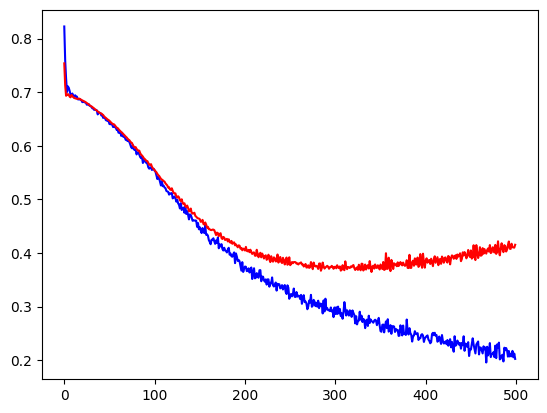

In [54]:
# Hyper-parameters
epochs = 500
learning_rate = 0.0008
validation_split = 0.2
dropout_rate = 0.3
batch_size = 1000
optimizer = k.optimizers.Adam(learning_rate=learning_rate)

sig_shape =  len(X[0])
data_in = k.Input(shape = (sig_shape,), name= "data_input")

val = k.layers.Dense(units=20, name="dense1",activation='relu')(data_in)
val = k.layers.Dropout(dropout_rate)(val)
val = k.layers.Dense(units=12, name="dense2",activation='relu')(val)
val = k.layers.Dropout(dropout_rate)(val)
out = k.layers.Dense(units=1, name="out",  activation='sigmoid')(val)

model = k.Model(inputs=data_in,outputs=out)
model.compile(optimizer=optimizer,loss=k.losses.binary_crossentropy,metrics='accuracy')

#model.summary()
hist = model.fit(x=X,y=y,epochs=epochs,batch_size=batch_size, shuffle=True, validation_split=validation_split)
loss, accuracy = model.evaluate(x=X,y=y)
print(f"Loss:{loss}, Accuracy: {accuracy}")
# Validation loss and training loss graphs

plt.plot(hist.history['loss'], c='b')
plt.plot(hist.history['val_loss'], c='r')

epochs = 500
learning_rate = 0.0001
validation_split = 0.2
dropout_rate = 0.5
optimizer = k.optimizers.experimental.RMSprop(learning_rate=learning_rate)

Loss:0.31431272625923157, Accuracy: 0.9039999842643738


epochs = 100
learning_rate = 0.0001
validation_split = 0.2
dropout_rate = 0.5
batch_size = 200
optimizer = k.optimizers.experimental.RMSprop(learning_rate=learning_rate)
loss: 0.6388 - accuracy: 0.6300 - val_loss: 0.6397 - val_accuracy: 0.6840
 Accuracy: 0.7059999704360962